## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import time
import datetime as dt
import urllib.request, json
import os
from pandas_datareader import data

Using TensorFlow backend.


## Getting data using Alpha Vantage API

In [2]:
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # GOOGL stock market prices
    ticker = "GOOGL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [3]:
df = pd.read_csv("stock_market_data-GOOGL.csv")

In [4]:
df = df[['Date', 'Open', 'Close', 'Low', 'High']]

In [5]:
df = df.sort_values('Date')

Past 13 years stock data

In [6]:
df.head()

,Date,Open,Close,Low,High
3223,2004-08-19,50.1598,50.3228,48.1286,52.1911
800,2004-08-20,50.6614,54.3227,50.4056,54.7089
931,2004-08-23,55.5515,54.8694,54.6938,56.9157
1775,2004-08-24,55.7922,52.5974,51.9454,55.9728
588,2004-08-25,52.5422,53.1641,52.1008,54.1672


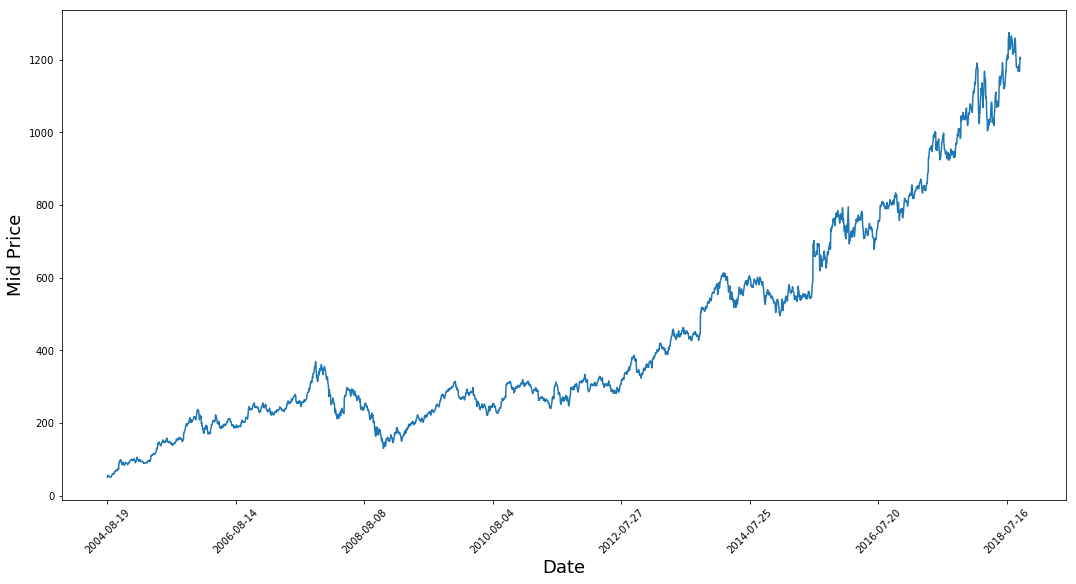

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [8]:
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
df["Mid Prices"] = (high_prices+low_prices)/2.0

In [9]:
df.head()

,Date,Open,Close,Low,High,Mid Prices
3223,2004-08-19,50.1598,50.3228,48.1286,52.1911,50.15985
800,2004-08-20,50.6614,54.3227,50.4056,54.7089,52.55725
931,2004-08-23,55.5515,54.8694,54.6938,56.9157,55.80475
1775,2004-08-24,55.7922,52.5974,51.9454,55.9728,53.95910
588,2004-08-25,52.5422,53.1641,52.1008,54.1672,53.13400


## Data Cleaning

In [10]:
df.drop("Date", axis = 1,inplace = True)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
df = scaler.transform(df)

## Building Long-Short Term Memory Cell to implement Recurrent Neural Network

In [14]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=50,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print ('compilation time : ', time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Load data as per model requirements

In [15]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result =  np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [16]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3193, 5, 5)
y_train (3193,)
X_test (355, 5, 5)
y_test (355,)


In [17]:
model = build_model([5,window,1])

C:\Users\shiva\Anaconda2\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\shiva\Anaconda2\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, input_shape=(None, 5), return_sequences=True)`
  import sys


compilation time :  0.02988910675048828


C:\Users\shiva\Anaconda2\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


## Training Time!

In [22]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,
    validation_split=0.1,
    verbose=1)

Train on 2873 samples, validate on 320 samples
Epoch 1/100
2873/2873 [==============================] - 1s 177us/step - loss: 0.0044 - val_loss: 0.0210
Epoch 2/100
2873/2873 [==============================] - 1s 174us/step - loss: 0.0069 - val_loss: 0.0078
Epoch 3/100
2873/2873 [==============================] - 1s 180us/step - loss: 0.0043 - val_loss: 0.0081
Epoch 4/100
2873/2873 [==============================] - 0s 172us/step - loss: 0.0051 - val_loss: 0.0139
Epoch 5/100
2873/2873 [==============================] - 0s 174us/step - loss: 0.0059 - val_loss: 0.0084
Epoch 6/100
2873/2873 [==============================] - 0s 172us/step - loss: 0.0037 - val_loss: 0.0167
Epoch 7/100
2873/2873 [==============================] - 0s 168us/step - loss: 0.0067 - val_loss: 0.0063
Epoch 8/100
2873/2873 [==============================] - 1s 178us/step - loss: 0.0042 - val_loss: 0.0193
Epoch 9/100
2873/2873 [==============================] - 1s 187us/step - loss: 0.0055 - val_loss: 0.0063
Epoch 10

Epoch 78/100
2873/2873 [==============================] - 1s 176us/step - loss: 0.0052 - val_loss: 0.0039
Epoch 79/100
2873/2873 [==============================] - 0s 166us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 80/100
2873/2873 [==============================] - 1s 181us/step - loss: 0.0045 - val_loss: 0.0026
Epoch 81/100
2873/2873 [==============================] - 1s 198us/step - loss: 0.0046 - val_loss: 0.0022
Epoch 82/100
2873/2873 [==============================] - 1s 206us/step - loss: 0.0028 - val_loss: 0.0039
Epoch 83/100
2873/2873 [==============================] - 1s 186us/step - loss: 0.0062 - val_loss: 0.0031
Epoch 84/100
2873/2873 [==============================] - 1s 187us/step - loss: 0.0029 - val_loss: 0.0036
Epoch 85/100
2873/2873 [==============================] - 1s 187us/step - loss: 0.0043 - val_loss: 0.0117
Epoch 86/100
2873/2873 [==============================] - 0s 171us/step - loss: 0.0036 - val_loss: 0.0098
Epoch 87/100
2873/2873 [======================

In [23]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)

0.00288910607937


## Predictions

In [24]:
p = model.predict(X_test)

## Visualizations

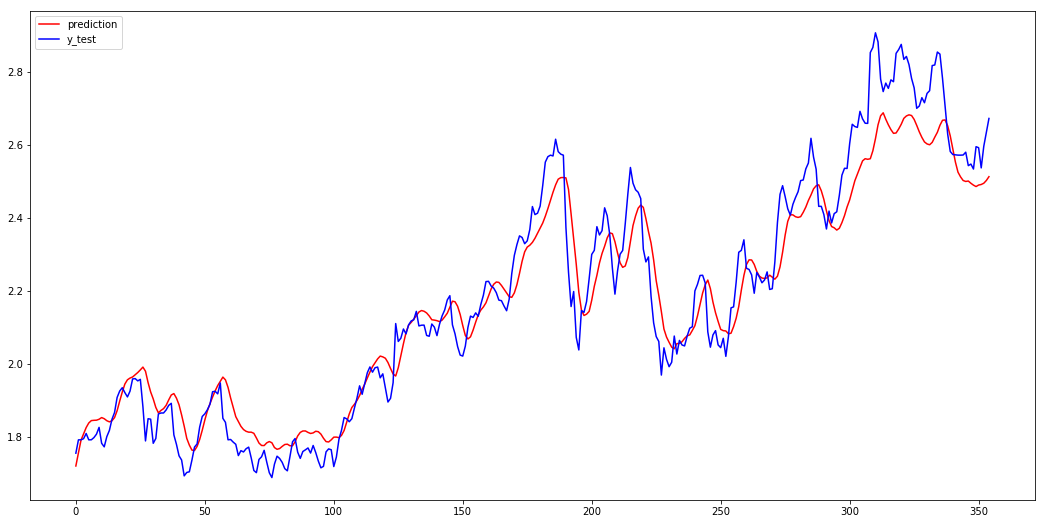

In [25]:
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()